In [13]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 1
C = 3 # number of channels of the input image
H = 640 # heigh of the input image
W = 640 # width of the input image

# mAP CARACTERIZATION

# Base model

In [ ]:
model = YOLO('weights/best.pt', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

# TRT fp32

In [ ]:
model = YOLO('weights/best_fp32.engine', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

# TRT fp16

In [ ]:
model = YOLO('weights/best_fp16.engine', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

# TRT int8

In [ ]:
model = YOLO('weights/best_int8.engine', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

# PIXEL TO PIXEL CARACTERIZATION

## Compare output segmentations masks

In [6]:
image = cv2.imread("datasets/salmons/images/val/Img3.jpeg")
resized_image = cv2.resize(image, (H, W))
cv2.imwrite("datasets/salmon_resized.png", resized_image)

True

In [7]:
base_model = YOLO('weights/yolov11salmons.pt', task='segment')
trt_model =  YOLO('weights/yolov11salmons_fp16.engine', task='segment')
results_base = base_model.predict("datasets/salmon_resized.png",show_boxes=False,save=True, conf=0.4)
results_trt = trt_model.predict("datasets/salmon_resized.png", show_boxes=False,save=True, conf=0.4)


image 1/1 /home/juam/Documents/SalmonsTRT/datasets/salmon_resized.png: 640x640 43 salmons, 130.0ms
Speed: 3.7ms preprocess, 130.0ms inference, 699.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/predict3
Loading weights/yolov11salmons_fp16.engine for TensorRT inference...
[12/19/2024-22:34:17] [TRT] [I] Loaded engine size: 82 MiB
[12/19/2024-22:34:17] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +80, now: CPU 0, GPU 80 (MiB)
[12/19/2024-22:34:17] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +47, now: CPU 1, GPU 127 (MiB)

image 1/1 /home/juam/Documents/SalmonsTRT/datasets/salmon_resized.png: 640x640 43 salmons, 55.5ms
Speed: 4.7ms preprocess, 55.5ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/predict4


In [8]:
# Obtener las máscaras de los resultados
masks_base = results_base[0].masks.data.cpu()  # Máscaras del modelo base
masks_trt = results_trt[0].masks.data.cpu()   # Máscaras del modelo optimizado

# Verificar que las dimensiones sean iguales
if masks_base.shape != masks_trt.shape:
    print("Las máscaras tienen dimensiones diferentes y no pueden compararse directamente.")
else:
    # Comparar igualdad exacta
    are_equal = np.array_equal(masks_base, masks_trt)
    print(f"¿Las segmentaciones son exactamente iguales? {'Sí' if are_equal else 'No'}")
    
    # Calcular el índice de Jaccard (IoU) promedio entre todas las máscaras
    iou_scores = []
    for mask_base, mask_trt in zip(masks_base, masks_trt):
        intersection = np.logical_and(mask_base, mask_trt).sum()
        union = np.logical_or(mask_base, mask_trt).sum()
        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)
    
    mean_iou = np.mean(iou_scores)
    print(f"Promedio del índice de Jaccard (IoU): {mean_iou:.4f}")


¿Las segmentaciones son exactamente iguales? No
Promedio del índice de Jaccard (IoU): 0.9469


In [9]:
def compare_images(image1, image2):
    # Leer imágenes en escala de grises
    img1 = cv2.imread(image1) # imagen del modelo base
    img2 = cv2.imread(image2) # imagen del modelo optimizado

    if img1.shape != img2.shape:
        raise ValueError("Las imágenes deben tener el mismo tamaño y número de canales")

    # Convertir a escala de grises
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Calcular la diferencia absoluta
    diferencia = cv2.absdiff(gray1, gray2)

    # Umbral para obtener las diferencias significativas
    _, imagen_binaria = cv2.threshold(diferencia, 10, 255, cv2.THRESH_BINARY)

    # Crear una máscara donde las diferencias sean no-cero
    mask = cv2.merge([imagen_binaria, imagen_binaria, imagen_binaria])

    # Crear una superposición roja
    overlay = np.zeros_like(img1, dtype=np.uint8)
    overlay[:, :, 2] = 255  # Canal rojo

    # Aplicar la superposición roja donde haya diferencias
    img1_con_diferencias = cv2.addWeighted(img1, 0.5, overlay, 0.5, 0.5)
    img1_con_diferencias[mask == 0] = img1[mask == 0]

    return img1_con_diferencias

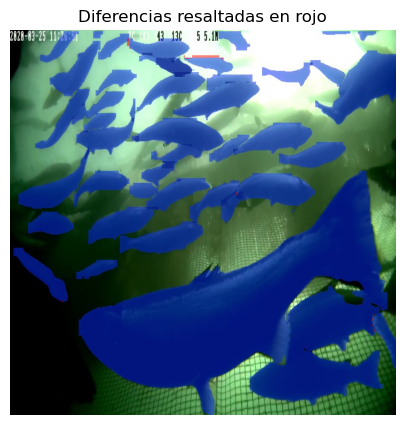

In [14]:
comparacion_binaria = compare_images('outputs/segmentation/salmon_vanilla.jpg','outputs/segmentation/salmon_fp16.jpg')
cv2.imwrite('outputs/segmentation/salmon_binario.jpg', comparacion_binaria)
# Mostrar la imagen con matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(comparacion_binaria, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente con matplotlib
plt.axis('off')  # Ocultar ejes
plt.title("Diferencias resaltadas en rojo")
plt.show()